# Анализ поведения пользователей мобильного приложения продуктов питания

<div class="alert alert-block alert-info">

Цель: изучить как пользователи доходят до покупки в приложении, сколько пользователей доходит, сколько не доходит и на каких шагах они останавливаются. Исследовать результаты A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одна экспериментальная — с новыми. Необходимо выяснить какой шрифт лучше.

План: 
- подготовить изучить и проверить данные
- проверить события и пользователей, период времени данных , актуальность данных, проверить выбросы
- проверить пользователей на уникальность в каждой группе
- изучить воронку событий, для этого сгпупперовать данные по группам
- посчитать события по группам, определить на каких этапах происходит резкое подение посещаемости
- изучить результаты эксперимента А/A/B теста

<div class="alert alert-success">


</div>
    

In [1]:
import pandas as pd                 #библиотека для считывания файлов с данными
import numpy as np                  #библиотека для оругления значений?
import matplotlib.pyplot as plt     #библиотека для графиков
from scipy import stats as st       #библиотека для проверки гипотез
import datetime 
import math as mth
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

# Шаг 1. Cчитываем документ и разделяем столбцы

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

- Выводим данные и смотрим информацию

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Из общей информации видно что : 
- нужно заменить тип данных времени с int на datetime
- и переименовать столбцы

# Шаг 2. Подготовка данных

- Заменим названия столбцов
- Проверим пропуски и типы данных
- Добавим столбец даты и времени, а также отдельный столбец дат
- Проверим явные дубликаты


переименовываем столбцы

In [5]:
data.rename(columns={'EventName':'event_name', 
                     'DeviceIDHash':'user_id', 
                     'EventTimestamp':'event_timestamp', 
                     'ExpId':'expid'}, inplace=True)

 - приводим данные даты в понятный формат
 - добовляем стобец event_time_s с датой и временем

In [6]:
data['event_time_s'] = pd.to_datetime(data['event_timestamp'], unit='s')

- добовляем стобец event_time_d только c датой

In [7]:
data['event_time_d'] = data['event_time_s'].dt.date.astype('datetime64')

пришлось во втором запросе добавить .astype('datetime64') тк изначально выводилось как object

In [8]:
data.head()

,event_name,user_id,event_timestamp,expid,event_time_s,event_time_d
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверяем кол-во пропусков

In [9]:
data.isna().sum()

event_name         0
user_id            0
event_timestamp    0
expid              0
event_time_s       0
event_time_d       0
dtype: int64

пропусков нет

Проверяем кол-во явных дубликатов

In [10]:
print('кол-во явных дубликатов =', data.duplicated().sum())

кол-во явных дубликатов = 413


Удалим явные дубликаты

In [11]:
data = data.drop_duplicates()

Снова проверим дубликаты

In [12]:
print('кол-во явных дубликатов =', data.duplicated().sum())

кол-во явных дубликатов = 0


посмотрим на общую информацию

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   expid            243713 non-null  int64         
 4   event_time_s     243713 non-null  datetime64[ns]
 5   event_time_d     243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


Что сделали:
- заменили названия столбцов на более удобные
- добалили столбц с датой и временем
- добалили столбц только с датой без времени
- проверили что пропусков нет
- удалили явные дубликаты

# Шаг 3. Изучим и проверим данные

- 3.1 Сколько всего событий в логе?
- 3.2 Сколько всего пользователей в логе?
- 3.3 Сколько в среднем событий приходится на пользователя?
- 3.4 Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- 3.5 Много ли событий и пользователей вы потеряли, отбросив старые данные?
- 3.6 Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

3.1 Сколько всего событий в логе?

In [14]:
print('У нас уникальных событий =', data['event_name'].nunique())

У нас уникальных событий = 5


посчитаем сколько раз каждое событие встречалось в датафрейме

In [15]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [16]:
print('Всего событий =', data['event_name'].count())

Всего событий = 243713


3.2 Сколько всего пользователей в логе?

In [17]:
print('Всего уникальных пользователей =', data['user_id'].nunique())

Всего уникальных пользователей = 7551


3.3 Сколько в среднем событий приходится на пользователя?

сгруперуем по пользователям и посчитаем кол-во событий приходящиеся на каждого пользователя

In [18]:
id_group_cnt = data.groupby(by='user_id').agg({'event_name': 'count'})
id_group_cnt.head()

,event_name
user_id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


найдем среднее кол-во событий на пользователя и округлим

In [19]:
round(id_group_cnt.mean())

event_name    32.0
dtype: float64

 В среднем на пользрвателя приходится 32 события

3.4 Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [20]:
data.sort_values(by='event_time_s')

,event_name,user_id,event_timestamp,expid,event_time_s,event_time_d
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [21]:
dt_max = data['event_time_d'].max()
print('Последняя дата =', dt_max)

Последняя дата = 2019-08-07 00:00:00


In [22]:
dt_min = data['event_time_d'].min()
print('Первая дата =', dt_min)

Первая дата = 2019-07-25 00:00:00


In [23]:
period_dt = dt_max - dt_min
print('Период времени которым мы распологаем =', period_dt)

Период времени которым мы распологаем = 13 days 00:00:00


построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени

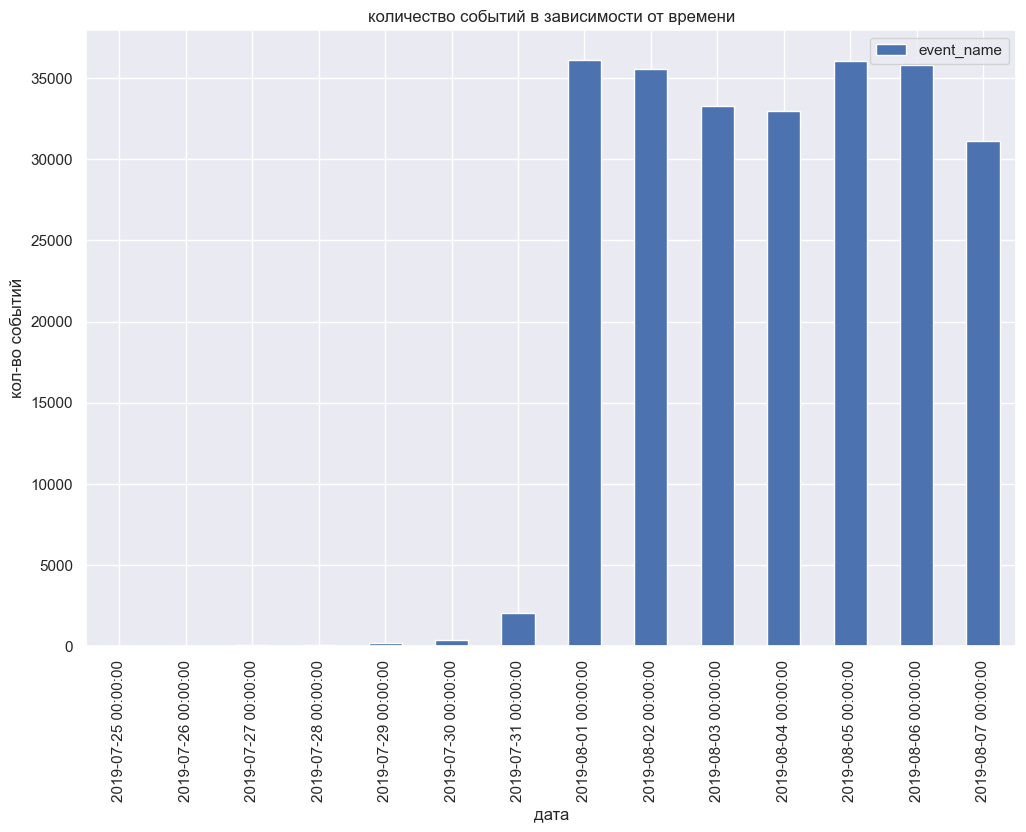

In [24]:
(
data
    .pivot_table(index='event_time_d',values='event_name', aggfunc='count')
    .sort_values(by='event_time_d', ascending=True)
    .plot(kind='bar', grid=True, title='количество событий в зависимости от времени')
)
plt.xlabel("дата")
plt.ylabel("кол-во событий")
plt.show()

построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп

построим пивот тайбл сгруперуем одновременно по группам пользователей 246 247 и 248 и дате, и посчитаем количество событий

In [25]:
df_events = (
data
    .pivot_table(index=['expid', 'event_time_d'],  values='event_name', aggfunc='count')
    
)
df_events.head()

event_name
expid event_time_d            
246   2019-07-25             4
      2019-07-26            14
      2019-07-27            24
      2019-07-28            33
      2019-07-29            55

нужно сделать индексами только группы, для этого сбросим и переназначим индекс

In [26]:
# сбросим индекс
df_events = df_events.reset_index()
df_events.head()

,expid,event_time_d,event_name
0,246,2019-07-25,4
1,246,2019-07-26,14
2,246,2019-07-27,24
3,246,2019-07-28,33
4,246,2019-07-29,55


In [27]:
# назначим новый индекс
df_events = df_events.set_index('expid')
df_events.head()

,event_time_d,event_name
expid,,
246,2019-07-25,4
246,2019-07-26,14
246,2019-07-27,24
246,2019-07-28,33
246,2019-07-29,55


построим столбчатые диаграммы, которые отобразят количество событий в зависимости от времени в разрезе групп в цикле

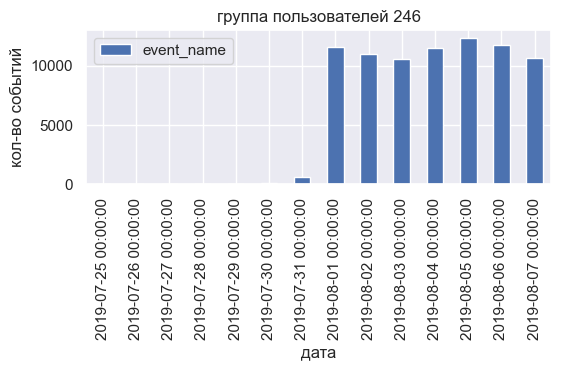

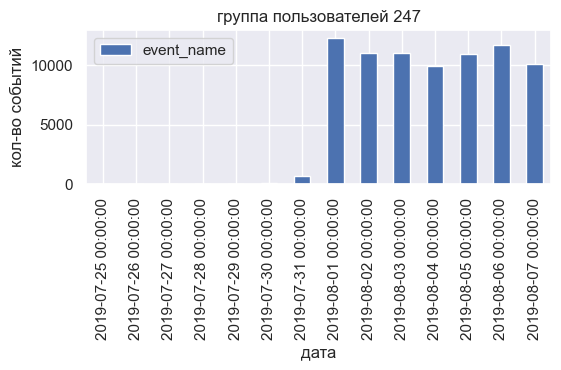

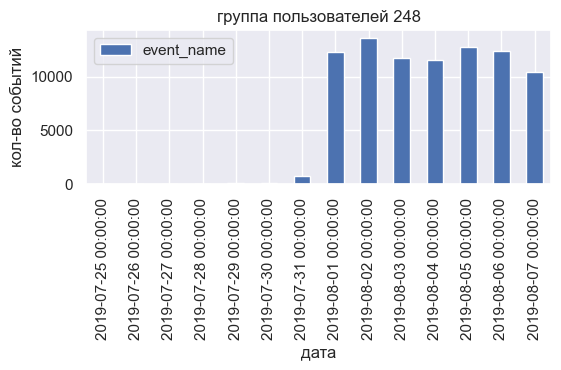

In [28]:
for gr in df_events.index.unique():
    platform_sales_all_pivot = (
        df_events
    .query('expid == @gr')
    .pivot_table(index='event_time_d', values='event_name', aggfunc='sum')
    .plot(kind='bar', grid=True, figsize=(6,2)) )
    
    plt.ylabel('кол-во событий')
    plt.xlabel('дата')
    plt.title('группа пользователей ' + str(gr))
    plt.show()

Из графиков видно что данные не равномерны. Определим что полные данные с 2019-08-01 числа остальное отбросим. Получается актуальный период с 2019-08-01 по 2019-08-07 и равен 7 дней

3.5 Много ли событий и пользователей вы потеряли, отбросив старые данные?

сделаем срез отбросив события до 2019-08-01 числа

In [29]:
data1 = data.query('event_time_d >= "2019-08-01"')

посчитаем сколько событий мы потеряли

In [30]:
print('Мы потеряли', data['event_name'].count() - data1['event_name'].count(), 'событий')
print('и')
print(data['user_id'].nunique() - data1['user_id'].nunique(), 'пользователей')

Мы потеряли 2826 событий
и
17 пользователей


<div class="alert alert-block alert-info">
    
посчитаем сколько процентов это составляет

In [31]:
# расчитаем сколько событий потеряли в процентах 
round( ( data['event_name'].count() - data1['event_name'].count() ) / data['event_name'].count() *100, 2 )

1.16

In [32]:
# расчитаем сколько пользователей потеряли в процентах 
round( (data['user_id'].nunique() - data1['user_id'].nunique())/data['user_id'].nunique() * 100, 2)

0.23

<div class="alert alert-block alert-info">
    
отфильтровав данные мы потеряли:
- 2826 событий это составляет - 1%;
- 17 пользователей - 0.23%

3.6 Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

cгруперуем и посчитаем уникальных пользователей

In [33]:
grp_expid = data1.groupby(by='expid').agg({'user_id':'nunique'})
grp_expid['rate_%'] = round(grp_expid['user_id']/grp_expid['user_id'].sum()*100, 2)
grp_expid

,user_id,rate_%
expid,,
246,2484,32.97
247,2513,33.36
248,2537,33.67


получили почти одинаковое число уникальных пользователей в каждой группе

# Шаг 4. Изучим воронку событий

- 4.1 Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- 4.2 Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- 4.3 Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- 4.4 По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- 4.5 На каком шаге теряете больше всего пользователей?
- 4.6 Какая доля пользователей доходит от первого события до оплаты?

4.1 Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [34]:
data1['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

4.2 Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [35]:
df2 = data1.groupby(by='event_name').agg({'user_id':'nunique'})
df2 = df2.sort_values(by='user_id', ascending = False)
df2['rate_%'] = round(df2['user_id'] / data1['user_id'].nunique() * 100, 2)
df2

,user_id,rate_%
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


4.3 Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

думаю лонично расположить их в таком порядке 
- MainScreenAppear - Главный экран
- Tutorial - руководство
- OffersScreenAppear - Предложения
- CartScreenAppear - Корзина
- PaymentScreenSuccessful - Успешный Платеж

не все смотрят руководство, а все остальное в порядке убывания из таблицы df2

4.4 По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Создадим новый столбец конверсий и рассчитаем их в цикле

df2['conversion'] = 0
for i in range(0, len(df2['rate_%'])):
    if i == 0:
        df2['conversion'].iloc[i] = 100
    else:
        df2['conversion'].iloc[i] = round(int(df2['user_id'].iloc[i]) / int(df2['user_id'].iloc[i-1]), 2)*100

In [36]:
#df2['conversion'] = 0
df2.loc[0, 'conversion'] = 100

df2['conversion'] = df2['user_id'].div(df2['user_id'].shift(1)).mul(100).round(2)

In [37]:
df2 = df2.query('event_name != "Tutorial" and event_name != 0')
df2

,user_id,rate_%,conversion
event_name,,,
MainScreenAppear,7419.0,98.47,NaN
OffersScreenAppear,4593.0,60.96,61.91
CartScreenAppear,3734.0,49.56,81.30
PaymentScreenSuccessful,3539.0,46.97,94.78


Text(0, 0.5, 'кол-во посещений')

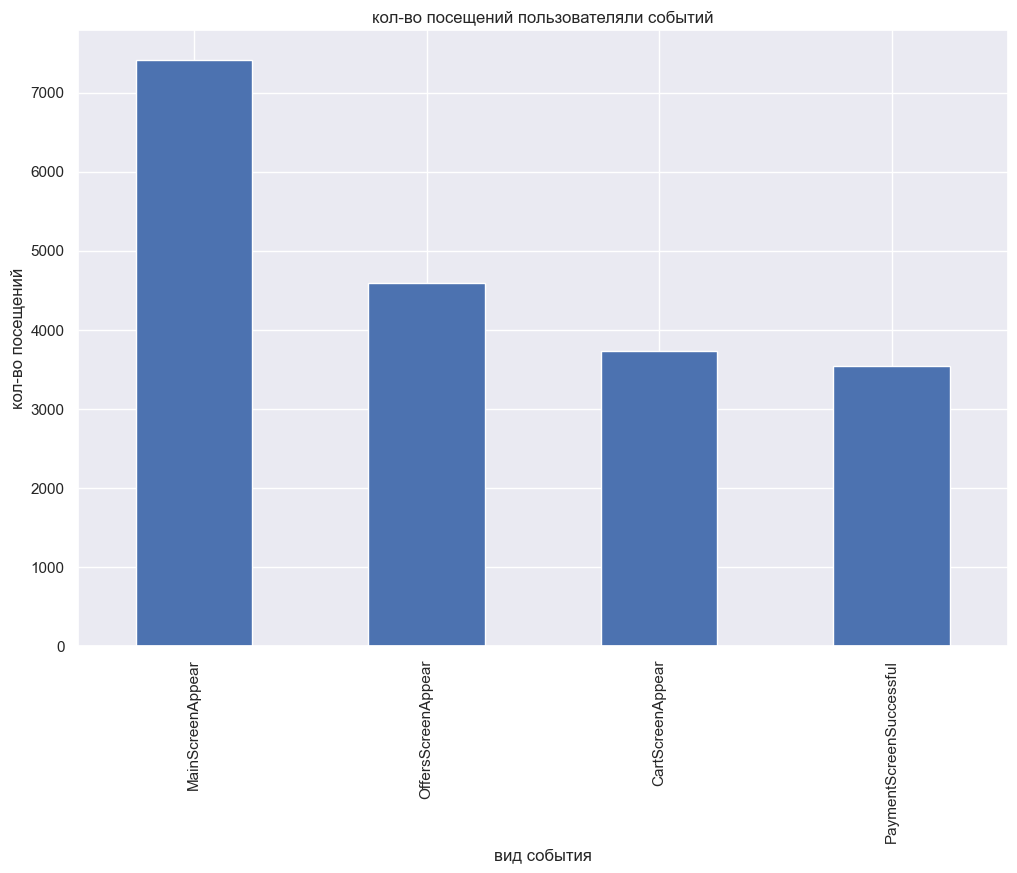

In [38]:
df2['user_id'].plot(kind='bar', grid=True, title='кол-во посещений пользователяли событий')
plt.xlabel("вид события")
plt.ylabel("кол-во посещений")

<div class="alert alert-block alert-info">
    v2
    
исключил из графика tutorial
    

<div class="alert alert-block alert-info">
    
- Визуализировали график воронки
- Наглядно видно где больше всего потеря пользователей

- По предложением проходит 62% пользователей, посмотревших главный экран. 
- В корзину переходит 81% пользователей. 
- Успешная оплата происходит у 95% пользователей.

4.5 На каком шаге теряете больше всего пользователей?

На первом шаге теряется больше всего пользователей при переходе с главного экрана на предложения

4.6 Какая доля пользователей доходит от первого события до оплаты?

До оплаты доходит 47% пользователей, это видно из датафрейма df2 - rate_% - PaymentScreenSuccessful тк там уже посчитали процент пользователей от общего числа всех уникальных пользователей

# Шаг 5. Изучим результаты эксперимента

- 5.1 Сколько пользователей в каждой экспериментальной группе?
- 5.2 Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- 5.3 Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- 5.4 Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- 5.5 Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

5.1 Сколько пользователей в каждой экспериментальной группе?

In [39]:
grp_expid

,user_id,rate_%
expid,,
246,2484,32.97
247,2513,33.36
248,2537,33.67


кол-во пользователей в каждой экспериментальной группе и процентное соотношение от общего кол-ва пользователей

<div class="alert alert-block alert-info">
    
- проверим поподают ли пользователи в несколько групп одновременно
- сгрупперуем по пользователям и посчитаем уникальные группы
- отсортируем тех кто поподает больше чем в одну группу

In [40]:
users_in_2_groups = (data1.groupby(by='user_id')
                          .agg({'expid': pd.Series.nunique})
                          .query('expid > 1') ).reset_index(drop=False)

In [41]:
users_in_2_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  0 non-null      int64
 1   expid    0 non-null      int64
dtypes: int64(2)
memory usage: 132.0 bytes


<div class="alert alert-block alert-info">
таких пользователей нет , данные собранны хорошо)

5.2 Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

5.3 Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [42]:
#Сделам таблицу с числом уникальных пользователей по событиям и контрольным группам
df_voronka = data1.pivot_table(index='expid',columns = 'event_name', values='user_id',aggfunc='nunique')
#del df_voronka['Tutorial']
df_voronka['user_cnt'] = [grp_expid['user_id'][246], grp_expid['user_id'][247], grp_expid['user_id'][248]]
df_voronka

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,user_cnt
expid,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


Напишем функцию для проверки гипотез

In [43]:
# функция для проверки гипотез A/B-теста
# df - датафрейм с данными
# gr1 - первая группа для сравнения (берется по индексу)
# gr2 - вторая группа для сравнения (берется по индексу)
# event_list - названия событий по которым берем данные 
      #(в виде списка можно проверить несколько событий, сначала нужно задать список)
# trials_col - общее число пользователей (берем колонку из дф)
# alpha - критический уровень статистической значимости

def test_groups_hypothesis (df, gr1, gr2, event_list, trials_col, alpha):
    
    for col in event_list:

    
        success = np.array([df[col][gr1], df[col][gr2]])
        trials = np.array([df[trials_col][gr1], df[trials_col][gr2]])

        # пропорция успехов в первой группе:
        p1 = success[0] / trials[0]
        # пропорция успехов во второй группе:
        p2 = success[1] / trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (success[0] + success[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Для метрики ', col)

        print('p-значение: ', p_value)

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
            print('\n')
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
            print('\n')

Сделаем проверку контрольных групп А/A

Сформулируем гипотезы:

**Нулевая гипотеза:** Статистически значимых различий в кол-ве пользователей между группами 246 и 247 **НЕТ**. Доли в двух выборках равны.

**Альтернативная гипотеза:** Статистически значимые различий в кол-ве пользователей между группами 246 и 247 **ЕСТЬ**. Доли в двух выборках не равны

Выберем значение **alpha = 0,05** 
Посчитаем статистическую значимость различий в количестве пользователей между группами 246 и 247 (А/А)

In [44]:
# задаем список event_list с событиями
#event_list = ['MainScreenAppear']
event_list = df_voronka.columns[:-2]
event_list

Index(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful'],
      dtype='object', name='event_name')

<div class="alert alert-block alert-info">
убрали tutorial

подставим: test_groups_hypothesis (df, gr1, gr2, event_list, trials_col, alpha)
- df - df_voronka
- gr1 первая группа - 246 (берем по индексу)
- gr2 вторая группа - 247 (берем по индексу)
- названия событий - event_list
- trials_col общее число пользователей из столбца - 'user_cnt'
- alpha критический уровень статистической значимости = 0.05

In [45]:
test_groups_hypothesis(df_voronka, 246, 247, event_list, 'user_cnt', 0.05)

Для метрики  CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




- Не получилось отвергнуть нулевую гипотезу, нет оснований считать контрольные выборки групп 246 и 247 разными.
- Контрольные группы выбраны верно.
- Можно сказать, что разбиение на группы работает корректно

5.4 Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Сделаем проверку групп 246 и 248

- Нулевая гипотеза: Статистически значимых различий между группами 246 и 248 НЕТ.
- Альтернативная гипотеза: Статистически значимые различий между группами 246 и 248 ЕСТЬ.
- Выберем значение alpha = 0,05 Посчитаем статистическую значимость различий в количестве пользователей между группами 246 и 248

In [46]:
test_groups_hypothesis(df_voronka, 246, 248, event_list, 'user_cnt', 0.05)

Для метрики  CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




- Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки групп 246 и 248 разными.

Сделаем проверку групп 247 и 248

In [47]:
test_groups_hypothesis(df_voronka, 247, 248, event_list, 'user_cnt', 0.05)

Для метрики  CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




- Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки групп 247 и 248 разными.

In [48]:
df_voronka

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,user_cnt
expid,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


объеденим группы 246 и 247 и назрвем ее 'new'

In [49]:
# Складываем строки:
df_voronka.loc['new'] = df_voronka.loc[246] + df_voronka.loc[247]
df_voronka

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,user_cnt
expid,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537
new,2504,4926,3062,2358,561,4997


Сделаем проверку групп 'new' и 248

In [50]:
test_groups_hypothesis(df_voronka, 'new', 248, event_list, 'user_cnt', 0.05)

Для метрики  CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




- Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки групп new и 248 разными.

- Между первой контрольной группой 246 и группой с измененными шрифтами 248 значимых различий нет. 
- Между группами 247 и 248 значимых различий нет. 
- Между объединенной контрольной группой new с группой 248 значимых различий нет.

5.5 Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

проведем еще раз все тесты с **alpha = 0,1**

Сделаем проверку групп 246 и 247

In [51]:
test_groups_hypothesis(df_voronka, 246, 247, event_list, 'user_cnt', 0.1)

Для метрики  CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




также Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 247 разными

Сделаем проверку групп 246 и 248

In [52]:
test_groups_hypothesis(df_voronka, 246, 248, event_list, 'user_cnt', 0.1)

Для метрики  CartScreenAppear
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница


Для метрики  MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




- Отвергаем нулевую гипотезу: между долями есть значимая разница в CartScreenAppear между группами 246 и 248
- тут получается меньше пользователей из группы 248 доходят до корзины?

Сделаем проверку групп 247 и 248

In [53]:
test_groups_hypothesis(df_voronka, 247, 248, event_list, 'user_cnt', 0.1)

Для метрики  CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




тут также Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными

Сделаем проверку групп 'new' и 248

In [54]:
test_groups_hypothesis(df_voronka, 'new', 248, event_list, 'user_cnt', 0.1)

Для метрики  CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для метрики  PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




аналогично Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки объединеной группы new и 248 разными.

<div class="alert alert-block alert-info">
    
вывод:
    
В данном проекте мы:
    
на этапе предобрадотки:
    
- заменили названия столбцов на более удобные
- добалили столбц с датой и временем
- добалили столбц только с датой без времени
- проверили что пропусков нет
- удалили явные дубликаты
    
    изучили и проверили данные:

- В среднем на пользрвателя приходится 32 события
    
    Из графиков выше было видно что данные не равномерны. поэтому мы приняли решение определить что полные данные с 2019-08-01  числа остальное отбросили. Получился актуальный период с 2019-08-01 по 2019-08-07 и равен 7 дней.  
    При этом мы потеряли: 2826 события это составляет - 1% от общего количества событий; и 17 пользователей - что составляет 0.23%. данное количество не считается значимым.
    
    - в логе имеются 5 уникальных события
    - каждое событие встречалось в датафрейме: 
- MainScreenAppear           117328
- OffersScreenAppear          46333
- CartScreenAppear            42303
- PaymentScreenSuccessful     33918
- Tutorial                     1005
- Всего событий = 240887    
- Всего уникальных пользователей = 7534  
- В среднем на пользрвателя приходится 32 события
    
Проверили, что у есть пользователи из всех трёх экспериментальных групп и получили почти одинаковое число уникальных пользователей в каждой группе.
    
Изучили воронку событий
    
выяснили что По предложением проходит 62% пользователей, посмотревших главный экран.
На первом шаге теряется больше всего пользователей при переходе с главного экрана на предложения.

До оплаты доходит 47% пользователей.
    
Изучили результаты эксперимента теста А/А/В
Сформулировали гипотезы и по результатам тестов выяснили что статистически значимых различий между группами тестирования НЕТ.
значит новый шрифт не отпугнет пользователей , но и не поможет повысить продажи.
    
    